In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
import os
root_path = '/content/gdrive/MyDrive/Project/Dravidian-Offensive-Language-Identification'
os.chdir(root_path)

In [2]:
!pip install sentencepiece
!pip install transformers
!pip install demoji
!pip install tweet-preprocessor

     |████████████████████████████████| 1.2MB 4.5MB/s 
     |████████████████████████████████| 2.2MB 5.9MB/s 
     |████████████████████████████████| 870kB 34.9MB/s 
     |████████████████████████████████| 3.3MB 33.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=e5e4b988be1392f546bfd4fc2e00e2b7f461b9109792e811d6863cc955993671
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [3]:
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
import copy
from transformers import BertModel, RobertaModel, BertTokenizer, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, random_split, DataLoader, IterableDataset, ConcatDataset
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score 
from tqdm import tqdm_notebook as tqdm
import demoji 
import random
demoji.download_codes() 
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 8})
RANDOM_SEED = 42

... OK (Got response in 0.16 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [ ]:
import pdb

In [ ]:
!git lfs install
!git clone https://huggingface.co/xlm-roberta-base

git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log
Cloning into 'xlm-roberta-base'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 8), reused 0 (delta 0)
Unpacking objects: 100% (24/24), done.


In [4]:
# model_path = 'bert-base-multilingual-cased'
# model_path = 'monsoon-nlp/tamillion'
model_path = "xlm-roberta-base"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value)  
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
random_seed(RANDOM_SEED, True)

In [6]:
class Dataset():
    def __init__(self, train_data, val_data, label_data, batch_size = 32):
        self.train_data = train_data
        self.val_data = val_data
        self.label_data = label_data
        self.batch_size = batch_size

        # self.label_dict = {'Not_offensive': 0,
        #                     'Offensive_Targeted_Insult_Group': 3,
        #                     'Offensive_Targeted_Insult_Individual': 5,
        #                     'Offensive_Targeted_Insult_Other': 2,
        #                     'Offensive_Untargetede': 4,
        #                     'not-Tamil': 1}
        self.label_dict = {'NOT': 0,
                            'OFF': 1}
                                    
        self.count_dic = {}

        self.train_inputs, self.train_labels = self.process_data(self.train_data)
        self.val_inputs, self.val_labels = self.process_val_data(self.val_data,self.label_data)
        count_dic = {}
        for data in self.train_labels:
            label = int(data)
            count_dic[label] = count_dic.get(label, 0)+1
        self.weights = torch.Tensor([len(self.train_labels)/count_dic[i] for i in range(2)]).to(device)
        self.train_dataloader = self.get_dataloader(self.train_inputs, self.train_labels)
        self.val_dataloader = self.get_dataloader(self.val_inputs, self. val_labels, train = False)

    def tokenize(self, sentences, padding = True, max_len = 256):
        # tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        input_ids, attention_masks = [], []
        for sent in sentences:
            encoded_dict = tokenizer.encode_plus(sent,
                                                    add_special_tokens=True,
                                                    max_length=max_len, 
                                                    padding='max_length', 
                                                    return_attention_mask = True,
                                                    return_tensors = 'pt', 
                                                    truncation = True)
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        return {'input_ids': input_ids, 'attention_masks': attention_masks}
    
    def process_data(self, data):
        sentences, labels = [], []
        print(len(data))
        for line in data:
            # pdb.set_trace()
            sentence = line.strip().split('\t')
            # sentence = line.strip().split(',')
            sentence = sentence[1:]
            label = sentence.pop()
            # if label == 'not-Kannada': print(sentence)
            if label not in self.label_dict:
                self.label_dict[label] = len(self.label_dict)
            sentence = p.clean(' '.join(sentence)).replace('#','')
            emoji_dict = demoji.findall(sentence)
            if len(emoji_dict): 
                for emoji, text in emoji_dict.items():
                    sentence = sentence.replace(emoji, ' '+text+' ')
                    sentence = ' '.join(sentence.split())
            sentences.append(sentence)
            labels.append(self.label_dict[label])
            # if label == 'not-Tamil': labels.append(1)
            # else: labels.append(0)
            self.count_dic[labels[-1]] = self.count_dic.get(labels[-1], 0) + 1
        inputs = self.tokenize(sentences)

        return inputs, torch.Tensor(labels)

    def process_val_data(self, data, label_data):
        sentences, labels = [], []
        print(len(data))
        for idx in range(len(data)):
            # pdb.set_trace()
            line = data[idx]
            sentence = line.strip().split('\t')
            # sentence = line.strip().split(',')
            sentence = sentence[1:]
            label = label_data[idx].strip().split(',')
            label = label[1:]
            label = label[0]
            # if label == 'not-Kannada': print(sentence)
            if label not in self.label_dict:
                self.label_dict[label] = len(self.label_dict)
            sentence = p.clean(' '.join(sentence)).replace('#','')
            emoji_dict = demoji.findall(sentence)
            if len(emoji_dict): 
                for emoji, text in emoji_dict.items():
                    sentence = sentence.replace(emoji, ' '+text+' ')
                    sentence = ' '.join(sentence.split())
            sentences.append(sentence)
            labels.append(self.label_dict[label])
            # if label == 'not-Tamil': labels.append(1)
            # else: labels.append(0)
            self.count_dic[labels[-1]] = self.count_dic.get(labels[-1], 0) + 1
        inputs = self.tokenize(sentences)

        return inputs, torch.Tensor(labels)
    
    def get_dataloader(self, inputs, labels, train = True):
        data = TensorDataset(inputs['input_ids'], inputs['attention_masks'], labels)
        if train:
            sampler = RandomSampler(data)
        else:
            sampler = SequentialSampler(data)
        return DataLoader(data, sampler=sampler, batch_size=self.batch_size)

In [ ]:
!ls

 Datasets    'RNN Models'		     Transformers_Inference.ipynb
'ML Models'   Transformer_Architecture.jpg   xlm-roberta-base
 README.md   'Transformer Models'


In [7]:
with open('/content/gdrive/MyDrive/Project/Dravidian-Offensive-Language-Identification/Datasets/Turkish/offenseval-tr-training-v1.tsv', 'r') as f:
    train_data = f.readlines()
with open('/content/gdrive/MyDrive/Project/Dravidian-Offensive-Language-Identification/Datasets/Turkish/offenseval-tr-testset-v1.tsv', 'r') as f:
    val_data = f.readlines()
with open('/content/gdrive/MyDrive/Project/Dravidian-Offensive-Language-Identification/Datasets/Turkish/offenseval-tr-labela-v1.tsv', 'r') as f:
    label_data = f.readlines()    

In [ ]:
len(train_data)

31756

In [ ]:
train_data[:10]

["20948\t@USER en güzel uyuyan insan ödülü jeon jungkook'a gidiyor...\tNOT\n",
 '10134\t@USER Mekanı cennet olsun, saygılar sayın avukatımız,iyi günler dilerim\tNOT\n',
 '23457\tKızlar aranızda kas yığını beylere düşenler olduğunu görüyorum yapmayın allah aşkına\tNOT\n',
 '18401\tBiraz ders çalışayım. Tembellik ve uyku düşmanımızdır.\tNOT\n',
 '17525\t@USER Trezeguet yerine El Sharawy daha iyi olmaz mı\tNOT\n',
 '11996\t@USER Bence de olması gerekiyor. Hatta meslek lisesine ön hazırlık olarak ortaokulda bile çıraklık tarzında eğitimler verilip temeli hazırlanmalıdır. Lise çağına gelen bir çocuk için bir çok konuda vakit geçmiş oluyor. O nedenle de meslek liselerinde istenilen performans yakalanamıyor.\tNOT\n',
 '38452\tMutlu gorunumlu ama daima mutsuz olanlar burdami? Mutlu olun olmaya calisin sizi mutlu edecek seyler yapin cok dusunurseniz mutsuz olursunuz hayati akisina birakin zaten olacak birsey olacaksa birgun elbet olur siz yinede mutlu olun.\tNOT\n',
 '12615\t100 liraya tras old

In [ ]:
val_data[:10]

['41993\t@USER Sayın başkanım bu şekilde devam inşallah👏\n',
 '23000\tHerkes gevşekliği kadar duyar kasıyor,hayat böyle!\n',
 '42478\tOlgun ilişkisi olan arkadaş size en güzel hediye .\n',
 '21748\t@USER @USER Burada atıp tutacağına o kötü koşullarda 3 kuruşa sen çalışsana yiyorsa.\n',
 '13607\t@USER İşte o onur dediğin sende yok sorun o işte\n',
 '28439\t@USER @USER Düşük satsa sahip hacimli projelerin hepsinde  farazi trend çizgilerinin hacimli kırılışı takip edilmeli. HOT yakın dönemde bunu yaptı ve ciddi bir momentum kazandı. Bu kırılım sonrası nereye gideceği tahmini ise tamamen kehanet olur. Tavsiyem bir sonraki kırılımı beklemeniz.\n',
 '14664\t@USER Ama alırken annem odaya girdi hay aq\n',
 '22741\t@USER yeniden yapılanma sezon içinde kadro dışı kararları ile olmaz. bu taraftara suçlu sunmaktır. siz değil,yönetim gerekçeleri açıklamalıdır.\n',
 '40997\t@USER Günaydın melis hanım. Hangi yaşta olursan ol arada bir delilik yapmak insana iyi geliyor.Bence\n',
 '15724\t@USER Tamamen

In [ ]:
label_data[:10]

['41993,NOT\n',
 '23000,NOT\n',
 '42478,NOT\n',
 '21748,OFF\n',
 '13607,OFF\n',
 '28439,NOT\n',
 '14664,OFF\n',
 '22741,NOT\n',
 '40997,NOT\n',
 '15724,NOT\n']

In [ ]:
len(label_data)==len(val_data)

True

In [8]:
data =Dataset(train_data, val_data, label_data)

31756



3528


In [ ]:
data.train_inputs

{'attention_masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[     0,     22,  10577,  ...,      1,      1,      1],
         [     0,  84096,  30514,  ...,      1,      1,      1],
         [     0, 146000,    320,  ...,      1,      1,      1],
         ...,
         [     0,  58117,     25,  ...,      1,      1,      1],
         [     0,      6,  23920,  ...,      1,      1,      1],
         [     0,    799,  99671,  ...,      1,      1,      1]])}

In [9]:
# Save and Load Functions
def save_metrics(save_path, epochs, model, optimizer, F1):

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'epochs': epochs+1,
                  'F1': F1}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path, model, optimizer):
    try: 
        state_dict = torch.load(load_path, map_location=device)
        model.load_state_dict(state_dict['model_state_dict'])
        optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    except: 
        state_dict = {}

    print(f'Model loaded from <== {load_path}')
    
    return state_dict.get('epochs', 0), state_dict.get('F1', 0)

In [10]:
class Transform(torch.nn.Module):
    def __init__(self, D_in):
        super(Transform, self).__init__()
        self.embeddings = AutoModel.from_pretrained(model_path)
        self.dropout = nn.Dropout(0.3)
        self.final = nn.Linear(D_in*2, 2, bias = True)

    def forward(self, input_ids, mask):
        outputs = self.embeddings(input_ids, mask)
        out = outputs.last_hidden_state
        mean_pooling = torch.mean(out, 1)
        max_pooling, _ = torch.max(out, 1)

        embed = torch.cat((mean_pooling, max_pooling), 1)
        y_pred = self.final(self.dropout(embed))
        return y_pred

In [11]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
 
def get_predicted(preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    return pred_flat
 
def evaluate(test_dataloader, model, criterion, num_val_data):
    model.eval()
    avg_loss = 0.0
    num_correct = 0
    y_preds, y_test = np.array([]), np.array([])

    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
        with torch.no_grad():        
            ypred = model(b_input_ids, b_input_mask)
        loss = criterion(ypred, b_labels)
        num_correct += (torch.argmax(ypred, axis=1) == b_labels).sum().item()
        ypred = ypred.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_preds = np.hstack((y_preds, get_predicted(ypred)))
        y_test = np.hstack((y_test, label_ids))
        avg_loss += loss.item()
        
    
    print('Avg-Loss: {:.8f}\tValidation Accuracy: {:.8f}'.format(avg_loss / len(test_dataloader), num_correct / num_val_data))

    weighted_f1 = f1_score(y_test, y_preds, average='macro')
    return weighted_f1, y_preds, y_test
 
def train(training_dataloader, validation_dataloader, model, filepath, weights = None, learning_rate = 3e-5, epochs = 25, print_every = 10):
    total_steps = len(training_dataloader) * epochs
    no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps = 1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    current_epoch, best_weighted_f1 = load_metrics(filepath, model, optimizer)
    if weights == None:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.CrossEntropyLoss(weight=weights)
    
    for epoch_i in tqdm(range(current_epoch, epochs)):
        model.train()
        avg_loss = 0.0
        for step, batch in tqdm(enumerate(training_dataloader), total=len(training_dataloader)):
            b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
            # pdb.set_trace()
            outputs = model(b_input_ids, b_input_mask)
            loss = criterion(outputs, b_labels)
 
            # if step%print_every == 0:
            #     print(loss.item())
 
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            avg_loss += loss.item()
        print('Epoch: {}\tAvg-Loss: {:.8f}'.format(epoch_i, avg_loss / len(training_dataloader)))
 
        print('### Validation Set Stats')
        weighted_f1, ypred, ytest = evaluate(validation_dataloader, model, criterion, len(val_data))
        print("  Weighted F1: {0:.2f}".format(weighted_f1))
        if weighted_f1 > best_weighted_f1:
            best_weighted_f1 = weighted_f1
            save_metrics(filepath, epoch_i, model, optimizer, weighted_f1)

In [ ]:
len(val_data)

3528

In [12]:
model = Transform(768).to(device)

In [ ]:
print(torch.__version__)

1.8.1+cu101


In [ ]:
!pip install torch

In [ ]:
exit()

In [15]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps = 1e-8)
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps = 1e-8)
load_metrics('/content/gdrive/MyDrive/Project/Dravidian-Offensive-Language-Identification/Datasets/Turkish/turkish01.pt', model, optimizer)

Model loaded from <== /content/gdrive/MyDrive/Project/Dravidian-Offensive-Language-Identification/Datasets/Turkish/turkish01.pt


(2, 0.8754825682391689)

In [14]:
train(data.train_dataloader, data.val_dataloader, model, '/content/gdrive/MyDrive/Project/Dravidian-Offensive-Language-Identification/Datasets/Turkish/turkish04_macroF1.pt')

Model loaded from <== /content/gdrive/MyDrive/Project/Dravidian-Offensive-Language-Identification/Datasets/Turkish/turkish04_macroF1.pt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 0	Avg-Loss: 0.04203535
### Validation Set Stats


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Avg-Loss: 0.61291721	Validation Accuracy: 0.87783447
  Weighted F1: 0.80
Model saved to ==> /content/gdrive/MyDrive/Project/Dravidian-Offensive-Language-Identification/Datasets/Turkish/turkish04_macroF1.pt



Epoch: 1	Avg-Loss: 0.04381318
### Validation Set Stats



Avg-Loss: 0.65701150	Validation Accuracy: 0.87670068
  Weighted F1: 0.80
Model saved to ==> /content/gdrive/MyDrive/Project/Dravidian-Offensive-Language-Identification/Datasets/Turkish/turkish04_macroF1.pt



Epoch: 2	Avg-Loss: 0.05483678
### Validation Set Stats



Avg-Loss: 0.59791050	Validation Accuracy: 0.86224490
  Weighted F1: 0.78



Epoch: 3	Avg-Loss: 0.05791055
### Validation Set Stats



Avg-Loss: 0.75339498	Validation Accuracy: 0.87244898
  Weighted F1: 0.79



Epoch: 4	Avg-Loss: 0.06066962
### Validation Set Stats



Avg-Loss: 0.69344776	Validation Accuracy: 0.87386621
  Weighted F1: 0.78



Epoch: 5	Avg-Loss: 0.02973967
### Validation Set Stats



Avg-Loss: 0.78357799	Validation Accuracy: 0.86876417
  Weighted F1: 0.78



Epoch: 6	Avg-Loss: 0.03129435
### Validation Set Stats



Avg-Loss: 0.91678861	Validation Accuracy: 0.87925170
  Weighted F1: 0.79



Epoch: 7	Avg-Loss: 0.03116830
### Validation Set Stats



Avg-Loss: 0.95837651	Validation Accuracy: 0.87159864
  Weighted F1: 0.79



Epoch: 8	Avg-Loss: 0.02983296
### Validation Set Stats



Avg-Loss: 0.95956625	Validation Accuracy: 0.87670068
  Weighted F1: 0.78


KeyboardInterrupt: ignored

In [ ]:
model

Transform(
  (embeddings): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(

In [ ]:
# load_metrics('detect_lang_tamil_mbert_1.pt', model, optimizer)

In [18]:
weighted_f1, ypred, ytest = evaluate(data.val_dataloader, model, nn.CrossEntropyLoss(), len(val_data))
print(weighted_f1)
from sklearn.metrics import confusion_matrix
array = confusion_matrix(ytest, ypred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Avg-Loss: 0.31872864	Validation Accuracy: 0.87783447
0.8040393790420306


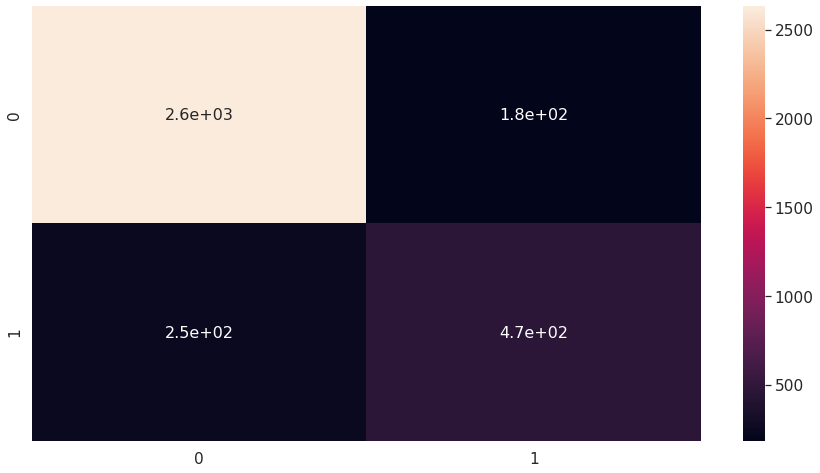

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()